# Lab 2: 

#### Goals:

+ Learn the innerworkings of `step_detached`
+ Learn how you can customize this step for your own needs

# 1. Introduction: Modifying the `detached_step`
Now that we have learned about the `detached_step`, let's have a look at what we can do to modify it. This is useful in case you are ever interested in testing out different prescriptions besides the defaults and for debugging binary evolution.

In this lab we will learn how to customize the `detached_step`. Both magnetic braking and tides are calculated naturally in the MESA stellar evolution grids, but we can't easily change prescriptions for those phenomena without rerunning the MESA models themselves, which is relatively time consuming. What if we want to quickly test a new treatment for magnetic braking or tides? In the example that we will work through below, you will learn how to modify the magnetic braking prescription of `step_detached` to implement an enable an entirely new capability not available in default POSYDON: neutron star magnetic braking.

Before we get there though, we need to understand how the `detached_step` works in a bit more detail than we have looked at so far. You can have a look at `$PATH_TO_POSYDON/posydon/binary_evol/DT/step_detached.py` to see things for yourself, but it might be a lot to take in. We can break down how things work like this:

**`step_detached`'s blueprint:**

1. Match any surviving stars from a binary to a single star MESA track
2. Solve the set of differential equations involving tides, magnetic braking, etc. until a star dies or starts RLOF
3. Update the stars with the result of detached evolution so that POSYDON knows where to send the binary next in the `flow`

Those are the basics. You have already seen a way to modify `step_CE` earlier in the week, and we will go about things in a similar way. We will take advantage of [Python's class inheritance mechanism](https://docs.python.org/3/tutorial/classes.html#inheritance) to do this. It all starts by importing the `detached_step` class and making our own child class from it (this can be done in the notebook or your own Python file).

In [ ]:
from posydon.binary_evol.DT.step_detached import detached_step

class my_detached_step(detached_step):

    pass

This is about as simple as we could get with creating our own `detached_step` class. Right now it does not do anything different at all from the usual one. We can check that by evolving a binary and comparing the outputs. Let's create our `SimulationProperties`, but this time replacing the usual `detached_step` with the child class (`my_detached_step`) that we just created.

In [ ]:
from posydon.binary_evol.simulationproperties import SimulationProperties

my_ini_path = 'population_params.ini'

my_kwargs = {}
my_kwargs['step_detached'] = (my_detached_step, {}) # direct to custom step

sim_prop = SimulationProperties.from_ini(my_ini_path, load_steps=True, metallicity=1, verbose=True, **my_kwargs)

We will also import the things we need to evolve a `BinaryStar` below. We will stick to simulating LMXB systems in tight orbits to have a better chance at seeing the effects of strong tides and magnetic braking.

___
<div class='alert alert-success'>
    
#### Exercise 1: Setup `BinaryStar` evolution for an LMXB

1. Import what you need to evolve a `BinaryStar` in the cell below.
2. Create a `BinaryStar` and/or write your own helper function (like the one used in the last lab) to create one.
3. Let's keep the focus on LMXB-type systems: 
    + Try an initial primary mass of 1.4 $\rm M_{\odot}$ for the neutron star and 1 $\rm M_{\odot}$ for the secondary HMS star. Place them at an initial orbital period of 2 days.

4. Evolve the `BinaryStar` and display its history `DataFrame`.
5. In the 2nd cell, create an LMXB system, but reload your `SimulationProperties` to use the original `step_detached` class instead.
6. Compare the two history `DataFrame`s

</div>

In [ ]:
# Evolve an LMXB with your custom detached step in this cell

In [ ]:
# Reload step_detached in your SimulationProperties object and re-run the binary, printing its history to compare the output

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>

### 1. Parts 1-4

```python
# imports
from posydon.binary_evol.binarystar import BinaryStar
from posydon.binary_evol.singlestar import SingleStar

# A function to handle creating a simple LMXB system
def create_a_co_star_system(star_mass, co_mass, co_type, ini_porb, sim_props):

    # the HMS stellar secondary
    star2 = SingleStar(**{'mass': star_mass,
                          'state': 'H-rich_Core_H_burning'})

    # the compact object primary
    star1 = SingleStar(**{'mass':co_mass,
                          'state': co_type})

    binary = BinaryStar(star1, star2,  
                        **{'time': 0.0,
                           'state': 'detached',
                           'orbital_period':ini_porb},
                           properties = sim_props)
    
    return binary

# call your function to create the LMXB
binary = create_a_co_star_system(star_mass=1.0, co_mass = 1.4, co_type='NS',
                                 ini_porb=2.0, sim_props=sim_prop)

# evolve the BinaryStar
binary.evolve()

# some useful bianry history columns to look at
cols = ['time', 'step_names', 'state', 'event', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass', 'orbital_period', 'separation','S1_log_R', 'S1_surf_avg_omega', 'S2_surf_avg_omega']

# actually showing the history dataframe (with our columns and evolution step names)
binary.to_df(extra_columns={'step_names':'string'})[cols]
```

### Parts 5 & 6

```python
# ===================================================================================

# Check out the history DataFrame above. Then, here's how you reload using the default 
# detached_step in SimulationProperties
sim_prop.load_a_step('step_detached', (detached_step, {}))

# re-run the LMXB
binary = create_a_co_star_system(star_mass=1.0, co_mass = 1.4, co_type='NS',
                                 ini_porb=2.0, sim_props=sim_prop)

binary.evolve()

cols = ['time', 'step_names', 'state', 'event', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass', 'orbital_period', 'separation','S1_log_R', 'S1_surf_avg_omega', 'S2_surf_avg_omega']

binary.to_df(extra_columns={'step_names':'string'})[cols]

# compare the outputs (they should look the same, because our custom detached step does not do anything yet.)

```
</details>

___

If all went well, you should see that indeed the two history `DataFrame`s are identical, and that right now `my_detached_step` does nothing new. Every class in Python has an `__init__()` function, which is what's called whenever you create a new instance of that class, and there's also the `__call__()` function that's used if you ever call your class like a function (i.e., like `output = my_class(arg1, arg2)`). These are known as ["dunder" methods](https://www.pythonmorsels.com/every-dunder-method/) in Python. Some (like `__init__`) are standard-use, while others are more obscure. In POSYDON's evolution steps, every class has at least an `__init__()` and a `__call__()` method, which are used to initialize the step's properties and perform all of the step's actions, respectively. 

Again, you can look at the `__call__()` function of `detached_step` in the corresponding Python file, but there's a lot going on and we will not need to mess with it to change the physics of this step. Referring back to the blueprint from the start though, the `__call__` dunder method is where all 3 of the actions performed by this step happen. You already saw a bit of the first step (track matching) in the last lab, and we will not mess with it here, but that happens within `__call__()` as well.

You can override any of these dunder methods and even call the parent class' dunder method for your own use. For example, if we wanted to customize the initialization step in our custom `detached_step`, we could do something simple like this:

In [ ]:
class my_detached_step(detached_step):

    def __init__(self, **kwargs):

        print("I just made my own detached step!")

Let's test it out...

In [ ]:
my_step = my_detached_step()

You should be able to see the `print` message that we added which gets output upon instantiation. That's a simple case, and not too useful for our needs. We will usually still want to do all the usual setup that the parent `detached_step` class does. Luckily we do not have to reinvent the wheel and can just call the `__init__()` method of the parent (referred to as the `super()` in a child class). That looks like this:

In [ ]:
class my_detached_step(detached_step):

    def __init__(self, **kwargs):

        # call the parent class' __init__ method to do
        # the usual initialization for this step
        super().__init__(**kwargs)

So for now, our custom step went back to doing everything that the usual `detached_step` does, but maybe you can see where things are going. In order to affect the actual physics going on in `step_detached`, we need to modify the `evo` (short for evolution) attribute of the `detached_step`. Let's take a quick look at what that looks like before we modify it:

In [ ]:
my_step = my_detached_step(metallicity=1.0)

my_step.evo

What you should see output in the cell above is something like `<posydon.binary_evol.DT.step_detached.detached_evolution at some_memory_reference>`. What this is telling you is that `evo` points to an object called `detached_evolution`.

## 1.1 The `detached_evolution` class

If we refer back to our simple blueprint from the start of the lab, the `detached_evolution` is a major component of step 2, solving the ODEs for detached evolution. This class holds all of the physics prescriptions that make up our set of ODEs that we solve to determine how the orbital separation, eccentricity, and stellar spins evolve through time during this phase of evolution. There are five functions that this class has that control all of the physics:

1. `sep_from_winds()`: evolve the orbital separation due to angluar momentum lost via winds
2. `tides()`: evolve the separation, eccentricity, and stellar spins due to tides
3. `magnetic_braking()`: evole the stellar spins due to magnetic braking
4. `gravitational_radiation()` : evolve the separation and eccentricity due to gravitational wave radiation
5. `spin_from_winds()`: evolve the stellar spins due to angular momentum lost through winds

These correspond to the five options that we mentioned in the last lab:

```python
  do_wind_loss = True
    # True, False
  do_tides = True
    # True, False
  do_gravitational_radiation = True
    # True, False
  do_magnetic_braking = True
    # True, False
  do_stellar_evolution_and_spin_from_winds = True
    # True, False
```

To alter the magnetic braking prescriptions and add neutron star magnetic braking, we will need to edit the `magnetic_braking()` function of the `detached_evolution` class. We already started making our own custom `detached_step`, but we will also need to create our own custom `detached_evolution` class and override the default `evo` property of the `detached_step` with it. Let's start simple and create our own `detached_evolution` and override the default `evo` in our custom `detached_step` before we start messing with the physics. Let's import the parent class and create a child class from it.

In [ ]:
from posydon.binary_evol.DT.step_detached import detached_evolution

# here's our custom detached_evolution class, doing nothing special yet
class my_detached_evolution(detached_evolution):

    pass

The `evo` attribute of `step_detached` gets assigned during the `__init__()` call, so we can assign our own `evo` after that's done. We can edit our custom `step_detached` to use our custom evolution like this:

In [ ]:
class my_detached_step(detached_step):

    def __init__(self, **kwargs):

        # call the parent class' __init__ method to do
        # the usual initialization for this step
        super().__init__(**kwargs)

        # then overwrite the default evolution with our custom one
        self.evo = my_detached_evolution(**self.evo_kwargs)

The `evo_kwargs` attribute is another thing that gets setup in the `super().__init__()` call. This attribute just holds all of the keyword arguments needed by the `detached_evolution` class, i.e., all of the 5 physics options above, plus the `magnetic_braking_mode`, which sets the magnetic braking prescription you want to use, and also a `primary` and `secondary` star, which are both `None` right now because we have not passed any stars into this step yet. Just to see, let's display the `kwargs` below:

In [ ]:
my_step.evo_kwargs

## 1.2 Solving the equations

So we have a custom `detached_step` and `detached_evolution`; we are nearly ready to start modifying the physics. Since we are modifying the ODes (specifically magnetic braking), let's give you the tools to have full control over this process before you are set loose to play around.

As said above, `detached_evolution` is one of the major components for solving the ODEs that simulate detached binary evolution in POSYDON, it is what holds the equations. To actually solve the equations, we use [`SciPy`'s `solve_ivp()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function to numerically integrate the system of equations, given a set of initial values. This is all contained within the `solve_ODEs()` method of `step_detached`, which looks like this inside of `detached_step`:


```python

# Here's where the ODEs are solved
def solve_ODEs(self, binary, primary, secondary):

    try:
        # try to solve using the Radau method
        res = solve_ivp(self.evo, 
                        events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                self.evo.ev_max_time1, self.evo.ev_max_time2],
                        method="Radau", 
                        t_span=(binary.time, self.max_time),
                        y0=[binary.separation, binary.eccentricity,
                            secondary.omega0, primary.omega0],
                        dense_output=True)
    except Exception:
        # and if that fails use the Runge-Kutta method
        res = solve_ivp(self.evo,
                        events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                self.evo.ev_max_time1, self.evo.ev_max_time2],
                        method="RK45",
                        t_span=(binary.time, self.max_time),
                        y0=[binary.separation, binary.eccentricity,
                            secondary.omega0, primary.omega0],
                        dense_output=True)
        
    return res

```

You can see that `solve_ivp()` is called, and we pass it the `detached_evolution` class held by the `evo` attribute. You can read more about the arguments used by `solve_ivp` if you take a look at its [docs page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). 

The things to know are that when `solve_ivp()` runs, it is solving the provided system of equations at a particular time `t`, in this case between `binary.time` (the current age of the binary at the start of `step_detached`) and `max_time`, which is the maximum age allowed by the simulation. Besides passing `evo` which `__call__`s the actual system of equations and returns a solution for the separation, eccentricity, and stellar spins at a particular time `t`,  take note of the `events` and `y0` arguments that we pass.

1. The `events` contains four methods that are used to detect Roche lobe overflow of star 1 and 2, and whether the maximum age of either star 1 or 2 has been reached during numerical integration; if any of these events are triggered, we exit `solve_ivp`, taking the last solution to be the result of `step_detached`. If we had RLOF, the binary will exit `step_detached` and be directed through the `flow` to either `step_CO_HMS_RLO` or `step_CO_HeMS_RLO` to continue its evolution.

2. The `y0` argument is what actually contains the initial values that we use to solve our ODEs. We pass the current `binary.separation`, `binary.eccentricity`, and the initial angular rotation rates `secondary.omega0` and `primary.omega0` to start things off. These initial values are all a result of the prior evolution and the track matching that is performed at the start of `step_detached`.

We will not mess with the `events`, but it turns out that we will need to adjust the initial conditions to implement neutron star magnetic braking. For now, let's just put a straight copy of `solve_ODEs` into our custom `detached_step` so that we have it for later.

In [ ]:
from scipy.integrate import solve_ivp

# here's our custom detached_evolution class, still doing nothing special
class my_detached_evolution(detached_evolution):

    pass


# our custom detached step
class my_detached_step(detached_step):

    def __init__(self, **kwargs):

        # call the parent class' __init__ method to do
        # the usual initialization for this step
        super().__init__(**kwargs)

        # then overwrite the default evolution with our custom one
        self.evo = my_detached_evolution(**self.evo_kwargs)

    # Here's where the ODEs are solved, we can mess with initial conditions here
    def solve_ODEs(self, binary, primary, secondary):

        try:
            # try to solve using the Radau method
            res = solve_ivp(self.evo, 
                            events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                    self.evo.ev_max_time1, self.evo.ev_max_time2],
                            method="Radau", 
                            t_span=(binary.time, self.max_time),
                            y0=[binary.separation, binary.eccentricity,
                                secondary.omega0, primary.omega0],
                            dense_output=True)
        except Exception:
            # and if that fails use the Runge-Kutta method
            res = solve_ivp(self.evo,
                            events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                    self.evo.ev_max_time1, self.evo.ev_max_time2],
                            method="RK45",
                            t_span=(binary.time, self.max_time),
                            y0=[binary.separation, binary.eccentricity,
                                secondary.omega0, primary.omega0],
                            dense_output=True)
            
        # return the result of evolution: the final separation, ecentricity, 
        #                                 spin of the secondary, and spin of 
        #                                 the primary at the end of detached 
        #                                 evolution
        return res

When we add `solve_ODEs` to our custom `detached_step` like this, it is called a method override; any time that you define a method with the same name as one that exists in the parent class, your new method will override the parent's. In this case, we still want to do the same thing as the parent's, but including it in our custom `detached_step` will give us the flexibility to edit things like the initial conditions of the ODEs, or other aspects of the numerical integration if we want to. So, now you have seen essentially all of the actions performed by `step_detached`, except the last part where we update the stars. Like with track matching (which you saw briefly in the last lab), we won't get too much into the weeds with this last step. However, we will want to update our neutron star with the result of our custom magnetic braking calculation, so we need to override the method that does that.

**Important: The calculations in `solve_ivp()` for the separation and stellar spins are solar radii and rad/year. When modifying physical prescriptions, it is important to use the appropriate units to produce proper results.**

## 1.3 Updating the stars with our solution

There are actually two separate methods that update the stars is `detached_step`. One of them updates normal stars, the other updates compact objects. The reason for the split is that compact objects are just point masses in POSYDON, so they don't actually have any values attibuted to them by default, or rather their attributes are all null, except for their mass. The method that updates compact objects is this one:

```python

    def update_co_stars(self, t, primary, secondary):

        """
            Update compact object properties after detached 
        evolution. The properties are updated here using the 
        CO star properties from the last step. Often, these 
        values are null.

        Parameters
        ----------
        t : float or array[float]
            This is the time elapsed as a result of detached 
            evolution in years. This is a float unless the 
            user specifies a timestep to use via the simulation 
            properties ini file, in which case it is an array.

        primary : SingleStar object
            A single star object, representing the primary (more evolved) star 
            in the binary and containing its properties.
        
        secondary : SingleStar object
            A single star object, representing the secondary (less evolved) star 
            in the binary and containing its properties.
        """

        for obj, prop in zip([secondary, primary],
                           [STARPROPERTIES, STARPROPERTIES]):
            
            # only update compact objects here
            if not obj.co:
                continue 

            for key in prop:

                # simply get the current attribute value and update
                # this step's props with it. Detached evolution does not
                # modify these properties for a CO by default, so they 
                # typically remain unchanged from the previous step.
                current = getattr(obj, key)
                history = [current] * len(t[:-1])
                setattr(obj, key, current)
                getattr(obj, key + "_history").extend(history)

```

It takes a time `t`, which is the time calculated at the end of detached evolution (i.e., the time at the end of `solve_ivp()`) -- this is passed automatically within `__call__` and we do not need to worry about it, just know that it is the current time of evolution at the end of detached evolution. In addition, this method needs a primary and secondary star to update, except it skips over any stars that are not compact objects. You can also read about each of the arguments in the method's doc string.

We will be calculating the spin of the neutron star in our calculations, so we will need to update this property of the neutron star with our results. Let's override the default `update_co_stars` method to do this, especially because the default is set up to just update compact object properties with whatever they were in the last step before `step_detached`. Let's throw this method into our custom `detached_step` now.

In [ ]:
from scipy.integrate import solve_ivp
from posydon.binary_evol.singlestar import STARPROPERTIES

# here's our custom detached_evolution class, still doing nothing special
class my_detached_evolution(detached_evolution):

    pass


# our custom detached step
class my_detached_step(detached_step):

    def __init__(self, **kwargs):

        # call the parent class' __init__ method to do
        # the usual initialization for this step
        super().__init__(**kwargs)

        # then overwrite the default evolution with our custom one
        self.evo = my_detached_evolution(**self.evo_kwargs)

    # Here's where the ODEs are solved, we can mess with initial conditions here
    def solve_ODEs(self, binary, primary, secondary):

        try:
            # try to solve using the Radau method
            res = solve_ivp(self.evo, 
                            events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                    self.evo.ev_max_time1, self.evo.ev_max_time2],
                            method="Radau", 
                            t_span=(binary.time, self.max_time),
                            y0=[binary.separation, binary.eccentricity,
                                secondary.omega0, primary.omega0],
                            dense_output=True)
        except Exception:
            # and if that fails use the Runge-Kutta method
            res = solve_ivp(self.evo,
                            events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                    self.evo.ev_max_time1, self.evo.ev_max_time2],
                            method="RK45",
                            t_span=(binary.time, self.max_time),
                            y0=[binary.separation, binary.eccentricity,
                                secondary.omega0, primary.omega0],
                            dense_output=True)
            

        # return the result of evolution: the final separation, ecentricity, 
        #                                 spin of the secondary, and spin of 
        #                                 the primary at the end of detached 
        #                                 evolution
        return res
    

    # we can use this to update the properties of the neutron star with our calculations
    def update_co_stars(self, t, primary, secondary):

        for obj, prop in zip([secondary, primary],
                           [STARPROPERTIES, STARPROPERTIES]):
            
            # only update compact objects here
            if not obj.co:
                continue 

            for key in prop:

                # simply get the current attribute value and update
                # this step's props with it. Detached evolution does not
                # modify these properties for a CO by default, so they 
                # typically remain unchanged from the previous step.
                current = getattr(obj, key)
                history = [current] * len(t[:-1])
                setattr(obj, key, current)
                getattr(obj, key + "_history").extend(history)

A couple things to note:

1. The list `STARPROPERTIES`, imported from `posydon.binary_evol.singlestar` contains all of the single star properties that POSYDON tracks during evolution. This is what we iterate over to update everything about a star after detached evolution. Most things don't change; really just the spins for each of the individual stars, but we still need to update the history of the star to keep track of what happened during this step. That's what the lines

```python
for key in prop:
    
    # get the current stellar property
    current = getattr(obj, key)

    # create a list of the history of this property in detached evolution, 
    # using the time after detached evolution `t`
    # NOTE: `t` can be a list if you specified a `dt` for `step_detached`
    history = [current] * len(t[:-1])

    # set the property's attribute with the current value after detached evolution
    setattr(obj, key, current)
    # extend the property history of the star with the values calculated in detached evolution
    getattr(obj, key + "_history").extend(history)

```

do in this method. In order to actually update the spin of the neutron star, we need to update its `surf_avg_omega` property, which is its angular rotation rate. We will take care of that later, but let's add a comment to our method to remind us to do this later.

Below, we added 

```python
    def update_co_stars(self, t, primary, secondary):

        ...

                # !!! ADD SOMETHING HERE LATER TO UPDATE THE NEUTRON STAR SPIN !!!
                # we will get back to this...
```

to our custom `detached_step`.

In [ ]:
from scipy.integrate import solve_ivp
from posydon.binary_evol.singlestar import STARPROPERTIES

# here's our custom detached_evolution class, still doing nothing special
class my_detached_evolution(detached_evolution):

    pass


# our custom detached step
class my_detached_step(detached_step):

    def __init__(self, **kwargs):

        # call the parent class' __init__ method to do
        # the usual initialization for this step
        super().__init__(**kwargs)

        # then overwrite the default evolution with our custom one
        self.evo = my_detached_evolution(**self.evo_kwargs)

    # Here's where the ODEs are solved, we can mess with initial conditions here
    def solve_ODEs(self, binary, primary, secondary):

        try:
            # try to solve using the Radau method
            res = solve_ivp(self.evo, 
                            events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                    self.evo.ev_max_time1, self.evo.ev_max_time2],
                            method="Radau", 
                            t_span=(binary.time, self.max_time),
                            y0=[binary.separation, binary.eccentricity,
                                secondary.omega0, primary.omega0],
                            dense_output=True)
        except Exception:
            # and if that fails use the Runge-Kutta method
            res = solve_ivp(self.evo,
                            events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                    self.evo.ev_max_time1, self.evo.ev_max_time2],
                            method="RK45",
                            t_span=(binary.time, self.max_time),
                            y0=[binary.separation, binary.eccentricity,
                                secondary.omega0, primary.omega0],
                            dense_output=True)
            

        # return the result of evolution: the final separation, ecentricity, 
        #                                 spin of the secondary, and spin of 
        #                                 the primary at the end of detached 
        #                                 evolution
        return res
    

    # we can use this to update the properties of the neutron star with our calculations
    def update_co_stars(self, t, primary, secondary):

        for obj, prop in zip([secondary, primary],
                           [STARPROPERTIES, STARPROPERTIES]):
            
            # only update compact objects here
            if not obj.co:
                continue 

            for key in prop:

                # !!! ADD SOMETHING HERE LATER TO UPDATE THE NEUTRON STAR SPIN !!!
                # we will get back to this...

                current = getattr(obj, key)
                history = [current] * len(t[:-1])
                setattr(obj, key, current)
                getattr(obj, key + "_history").extend(history)

Without further ado, let's get to implementing our new physics. This task is a bit more involved, but it might be along the lines of something that you would like to do in your own research some time. We will edit just the magnetic braking prescription, but you can take what you learn here and apply it to making changes in any of the other physical processes modeled in `step_detached`, or splice in some extra output maybe that aids you in an analysis.

Below, we wlll lay out the basic theory that we need to start understanding the equations that we will be working with. Then, we will put our new equations into the `magnetic_braking()` method of our custom `detached_evolution`.

# 2. Neutron Star Magnetic Braking 

In this tutorial, we will implement and test a simple magnetic braking prescription for neutron stars. Our goal is to:

1. Define a braking routine that evolves the neutron star’s spin frequency $\Omega$ at each timestep.

2. Incorporate this routine into the `step_detached` evolution step so that it only applies when the binary contains a neutron star.

3. Set up and evolve a test system (for example, a low-mass X-ray binary with a neutron star component) to examine how the neutron star’s spin evolves under this prescription.

4. Analyze the output history to track the spin frequency of the neutron star.

## 2.1 Basic Theoretical Overview

Neutron stars are born rapidly spinning as a result of angular momentum conservation during core collapse. Over time, they gradually spin down due to magnetic dipole radiation. The strong magnetic fields (typically $10^8$-$10^{13}$ G) anchored to their surfaces exert a torque as they interact with the surrounding plasma and radiate energy away. This torque extracts angular momentum from the neutron star, leading to a steady decrease in its rotational frequency. The classical dipole spin-down model predicts that the spin-down rate $\dot{\Omega} \propto - B^2 R^6 \Omega^3 / I$, where where $B$ is the surface magnetic field, $R$ is the neutron star radius, $\Omega$ is the angular frequency, and $I$ is the moment of inertia.

## 2.2 Our Implementation

In the code below, we shall define a function `my_NS_braking` that checks whether the primary or secondary star in the binary is a neutron star, and evolves the spin frequency $\Omega$ at every timestep within `step_detached`, using the standard magnetic dipole spin-down torque. Here are a few equations that summarize the braking model. 

The torque is computed as

\begin{equation}
\dot{\Omega} = -\frac{8 \pi R^6 \sin^2\alpha}{3 \mu_0 c^3 I} \, B^2 \Omega^3,
\end{equation}

where $R$ is the neutron star radius, $\alpha$ is the angle between the spin and magnetic axes, $\mu_0$ is the permeability of free space, $c$ is the speed of light, and $I$ is the moment of inertia of the neutron star. The moment of inertia is calculated following the fitting formula from [Tolman (1939)](https://ui.adsabs.harvard.edu/abs/1939PhRv...55..364T/abstract):

\begin{equation}
I = \frac{2}{7}
\left(1 - \frac{2.42\times 10^{-6} M}{R}
         - \frac{2.9\times 10^{-12} M^2}{R^2} \right)^{-1} M R^2,
\end{equation}

where $M$ and $R$ are the mass and radius of the neutron star (in solar units).  

We also include a simple prescription for magnetic field decay over time, given by

\begin{equation}
B(t) = \big(B_0 - B_{\min}\big) e^{-t/\tau_d} + B_{\min},
\end{equation}

where $B_0$ is the initial magnetic field, $B_{\min}$ is the asymptotic lower limit (set to $10^8\ \mathrm{G}$), and $\tau_d$ is the decay timescale (set to $1\ \mathrm{Gyr}$).

At each timestep, we update the spin frequency of both stars if they are neutron stars, and return the spin-down rate $d\Omega/dt$ in units of $\rm{rad/yr^{-2}}$. This framework allows neutron stars in our code to self-consistently spin down over time, coupling their rotational evolution to their magnetic field decay.

___
<div class='alert alert-success'>
    
#### Exercise 2: Writing our own prescription

1. Using the equations above, start to write your own function for neutron star magnetic braking.
2. Some of the code below is filled in, but the rest you will need to complete yourself.
3. Please ask for help if you get stuck!

<div class='alert alert-warning'>
    
**(Hint: You will need to assign/track the magnetic field of the neutron star. Recall that in Python, a class can always be given a new attribute like this `my_class.my_attr = some_value`.)**
    
</div>
</div>

In [ ]:
import posydon.utils.constants as const
import pandas as pd
import numpy as np


def my_NS_braking(t, primary, secondary, verbose=False):

    """
        Calculate the change in spin of a neutron star 
    due to magnetic braking, according to the theory 
    laid out in this lab.

    Parameters
    ----------

    t : float
        The current time during detached evolution, in years.

    primary : SingleStar
        A SingleStar instance holding data for the primary star.

    secondary : SingleStar
        A SingleStar instance holding data for the secondary star.

    verbose : bool
        This can be used to conditionally print information.

    """

    # an example of getting the primary star's mass/radius
    M1 = primary.mass       # [Msol]
    R1 = 10**primary.log_R   # [Rsol]

    M2 = # mass of the secondary
    R2 = # mass of the primary

    # some constants
    alpha = 45*const.a2rad          ## angle between the axis of rotation and magnetic axis [rad]
    mu_0 = 1                        ## permeability of free space [has value unity in cgs]
    B_min = 1e8                     ## minimum Bfield strength at which Bfield decay ceases [G]
    tau_d = 1e9*const.secyer        ## B-field decay timescale in Gyr [s]

    # every timestep, we will start anew with 0 change in
    # the rotation rate of both stars. Our goal is to 
    # calculate these below
    dOmega_pri = 0.0
    dOmega_sec = 0.0

    # write your code to calculate dOmega_pri and dOmega_sec
    # using the SingleStar properties and equations described
    # above

    # these are the resulting changes in rotation rate for the timestep, 
    # for the secondary and primary, make sure they are in [yr^-2]
    return dOmega_sec, dOmega_pri

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>

You can see below how we implemented the equations in our own function.

```python
import posydon.utils.constants as const
import pandas as pd
import numpy as np


def my_NS_braking(t, primary, secondary, verbose=False):

    M1 = primary.mass       # [Msol]
    R1 =10**primary.log_R   # [Rsol]

    M2 = secondary.mass
    R2 = 10**secondary.log_R

    dOmega_pri = 0.0
    dOmega_sec = 0.0

    def calc_moment_of_inertia(M, R):
        '''
        Calculate the moment of intertia of the NS [g*cm^2]
        Eq. from Kiel et al. 2008 is in solar units

        Calculations in [cgs], converted to rad/yr^-2 in the end
        '''

        return 2/7 * (1 - 2.42e-6*M/R - 2.9e-12*M**2/R**2)**-1 * M*R**2


    alpha = 45*const.a2rad          ## angle between the axis of rotation and magnetic axis [rad]
    mu_0 = 1                        ## permeability of free space [has value unity in cgs]
    B_min = 1e8                     ## minimum Bfield strength at which Bfield decay ceases [G]
    tau_d = 1e9*const.secyer        ## B-field decay timescale in Gyr [s]
   
    if primary.state == 'NS':

        I = calc_moment_of_inertia(M1, R1)

        ## evolve the NS spin
        A = 8*np.pi*R1**6*np.sin(alpha)**2/(3*mu_0*const.clight**3*I)
        dOmega_dt = -A * primary.B**2 * (primary.latest["omega"] / const.secyer)**3

        primary.B = (primary.B - B_min) * np.exp(-t/tau_d) + B_min

        dOmega_pri = dOmega_dt * const.secyer**2 # [s^-2] -> [yr^-2]

        if verbose:
            print("__________________________")
            print("t = ", t)
            print("B = ", primary.B)
            print("omega [rad/sec] = ", primary.latest["omega"] / const.secyer)
            print("omega [rad/yr] = ", primary.latest["omega"])
            print("dOmega_pri= ", dOmega_pri, "[rad/yr^2]")
            print("dOmega_pri= ", dOmega_pri / const.secyer**2, "[rad/s^2]")

    if secondary.state == 'NS':
        # calculate
        I = calc_moment_of_inertia(M2, R2)

        ## evolve the NS spin
        A = 8*np.pi*R2**6*np.sin(alpha)**2/(3*mu_0*const.clight**3*I)
        dOmega_dt = -A * secondary.B**2 * (secondary.latest["omega"] / const.secyer)**3

        secondary.B = (secondary.B - B_min) * np.exp(-t/tau_d) + B_min

        dOmega_sec = dOmega_dt * const.secyer**2 # [s^-2] -> [yr^-2]

    return dOmega_sec, dOmega_pri
```

</details>

## 2.3 Adding our prescription to `detached_evolution` 

Up until now, our custom `detached_evolution` has not been set up to do anything new. Let's change that now. We will want to override the default `magnetic_braking()` method of the `detached_evolution` class to incorporate our new magnetic braking prescription. We will still want to call the default `magnetic_braking()` method of the parent, which calculates the usual magnetic braking prescriptions for normal stars, and then call our new magnetic braking prescription for neutron stars.

___
<div class='alert alert-success'>

#### Exercise 3: Incorporating our new prescription

1. Override the default `magnetic_braking()` method of `detached_evolution`
2. Have the override method still call the parent's `magnetic_braking()` method so that normal stars are still spun down
3. After that, call your new prescription that calculations neutron star magnetic braking.
4. As before, some of the code is provided to get you started but you have to do the rest!
    
</div>

In [ ]:
# here's our custom detached_evolution class, still doing nothing special
class my_detached_evolution(detached_evolution):
    
    def magnetic_braking(self):

        # your code goes here!

        # update spins
        self.dOmega_pri += # change in spin for the primary from NS magnetic braking
        self.dOmega_sec += # change in spin for the secondary from NS magnetic braking

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>

```python
class my_detached_evolution(detached_evolution):
    
    # this function is what they overwrite inside of the `detached_evolution` class
    def magnetic_braking(self):

        super().magnetic_braking()
            
        # add your NS magnetic braking here
        dOmega_mb_sec_NS, dOmega_mb_pri_NS = my_NS_braking(self.t, self.primary, 
                                                            self.secondary, 
                                                            self.verbose)
        
        # update spins
        self.dOmega_sec += dOmega_mb_sec_NS
        self.dOmega_pri += dOmega_mb_pri_NS
```
    
</details>

Now we have incorporated our new prescription, we just need to do a few more bits of setup to get things working. Just above, remember that in this equation for the time evolution of the neutron star's magnetic field:

\begin{equation}
B(t) = \big(B_0 - B_{\min}\big) e^{-t/\tau_d} + B_{\min},
\end{equation}

we need an initial magnetic field strength, $B_0$. This is where the method we looked at before, `solve_ODEs()` comes in handy. In that method, we can set the initial conditions of our system of ODEs. We will need to assign a "birth" magnetic field for the neutron star, as well as a "birth" spin. Normally in POSYDON, compact objects do not have a rotation rate during detached evolution, so their initial spin is 0 by default; if we keep it that way, the neutron star will never spin down because you can't get any slower than 0! We need not be too detailed (we can't be, we're not modeling the spin or magnetic field evolution of the NS in any other evolution steps right now), so these can just be random but sensible values.

___
<div class='alert alert-success'>

#### Exercise 4: Assigning initial values for the ODE solver

1. In our custom `detached_step` class, assign initial values for the spin and magnetic field of the neutron star within `solve_ODEs()`
2. Use a random spin of between 100 and 10 ms (newborn neutron stars are born spinning about this fast)
3. Use a random magnetic field between 11.5 and 13.8 Gauss (typically for newborn neutron stars as well)
4. The initial magnetic field should be stored as an attribute of the neutron star.
5. Be sure that your new initial spin of the neutron star is passed as one of the initial values to `solve_ivp()` (i.e., in its `y0` argument).
    
</div>

In [ ]:
class my_detached_step(detached_step):

    def __init__(self, **kwargs):

        super().__init__(**kwargs)
        self.evo = my_detached_evolution(**self.evo_kwargs)


    def solve_ODEs(self, binary, primary, secondary):

        # setup your initialization here

        try:
            res = solve_ivp(self.evo, 
                            events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                    self.evo.ev_max_time1, self.evo.ev_max_time2],
                            method="Radau", 
                            t_span=(binary.time, self.max_time),
                            y0=[binary.separation, binary.eccentricity,
                                secondary.omega0, primary.omega0],
                            dense_output=True)
        except Exception:
            res = solve_ivp(self.evo,
                            events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                    self.evo.ev_max_time1, self.evo.ev_max_time2],
                            method="RK45",
                            t_span=(binary.time, self.max_time),
                            y0=[binary.separation, binary.eccentricity,
                                secondary.omega0, primary.omega0],
                            dense_output=True)
            
        return res
    
    # we can use this to update the properties of the neutron star with our calculations
    def update_co_stars(self, t, primary, secondary):

        for obj, prop in zip([secondary, primary],
                           [STARPROPERTIES, STARPROPERTIES]):
            
            # only update compact objects here
            if not obj.co:
                continue 

            for key in prop:

                # !!! ADD SOMETHING HERE LATER TO UPDATE THE NEUTRON STAR SPIN !!!
                # we will get back to this...

                current = getattr(obj, key)
                history = [current] * len(t[:-1])
                setattr(obj, key, current)
                getattr(obj, key + "_history").extend(history)

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>

```python
def solve_ODEs(self, binary, primary, secondary):

        if pd.isna(primary.surf_avg_omega):
            primary.surf_avg_omega = np.random.uniform(2*np.pi/1e-2, 2*np.pi/1e-1) # Abhishek
            primary.omega0 = primary.surf_avg_omega  * const.secyer# [s^-1] -> [yr^-1]
            primary.B = 10**np.random.uniform(11.5, 13.8) # Abhishek

        try:
            res = solve_ivp(self.evo, 
                            events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                    self.evo.ev_max_time1, self.evo.ev_max_time2],
                            method="Radau", 
                            t_span=(binary.time, self.max_time),
                            y0=[binary.separation, binary.eccentricity,
                                secondary.omega0, primary.omega0],
                            dense_output=True)
        except Exception:
            res = solve_ivp(self.evo,
                            events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                    self.evo.ev_max_time1, self.evo.ev_max_time2],
                            method="RK45",
                            t_span=(binary.time, self.max_time),
                            y0=[binary.separation, binary.eccentricity,
                                secondary.omega0, primary.omega0],
                            dense_output=True)
            
        return res
```

___
Of course, looming in the background is our message from before, inside `update_co_stars()`:


```python
# !!! ADD SOMETHING HERE LATER TO UPDATE THE NEUTRON STAR SPIN !!!
# we will get back to this...
```

and the time has come to do something about it. We need to update the `surf_avg_omega` property of our neutron star; this is its angular rotation rate in rad/sec. The result passed back by `solve_ODEs()` contains a [`OdeSolution` object](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.OdeSolution.html#scipy.integrate.OdeSolution) from SciPy's `solve_ivp()` function. This object is an interpolant, basically a function that you can give a time `t` and get back an interpolated value for one of the solutions that `solve_ivp` found near that time. Within `detached_step`, we can access this object like so:

```python
sep_interp, ecc_interp, omega_interp_sec, omega_interp_pri = self.res.sol(t)
```

which grants us access to the solution of the separation, eccentricity, secondary's rotation rate, and the primary's rotation rate at a time `t` during the detached evolution. So, we can use this to get the solution for the spin of our neutron star at some time (or times if we use the `dt` option in `step_detached`) `t`.

___
<div class='alert alert-success'>

#### Exercise 5: Updating stellar properties
1. Edit the `update_co_stars` method of our custom `detached_step` to update the rotation rate of the neutron star with our solution
2. The property to update is called `surf_avg_omega`
3. Remember that `solve_ivp()` works in units of rad/year, but otherwise POSYDON wants rad/sec for this property, so be careful to convert units properly,
</div>

In [ ]:
class my_detached_step(detached_step):

    def __init__(self, **kwargs):

        super().__init__(**kwargs)
        self.evo = my_detached_evolution(**self.evo_kwargs)


    def solve_ODEs(self, binary, primary, secondary):

        if pd.isna(primary.surf_avg_omega):
            primary.surf_avg_omega = np.random.uniform(2*np.pi/1e-2, 2*np.pi/1e-1)
            primary.omega0 = primary.surf_avg_omega  * const.secyer# [s^-1] -> [yr^-1]
            primary.B = 10**np.random.uniform(11.5, 13.8)

        try:
            res = solve_ivp(self.evo, 
                            events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                    self.evo.ev_max_time1, self.evo.ev_max_time2],
                            method="Radau", 
                            t_span=(binary.time, self.max_time),
                            y0=[binary.separation, binary.eccentricity,
                                secondary.omega0, primary.omega0],
                            dense_output=True)
        except Exception:
            res = solve_ivp(self.evo,
                            events=[self.evo.ev_rlo1, self.evo.ev_rlo2, 
                                    self.evo.ev_max_time1, self.evo.ev_max_time2],
                            method="RK45",
                            t_span=(binary.time, self.max_time),
                            y0=[binary.separation, binary.eccentricity,
                                secondary.omega0, primary.omega0],
                            dense_output=True)
            
        return res
    
    # we can use this to update the properties of the neutron star with our calculations
    def update_co_stars(self, t, primary, secondary):

        # get the solutions for separation, eccentricity, and the rotation rates of the secondary/primary
        # using the self.res.sol object
        # Remember that `t` here is the either the final time or times during detached evolution
        # and may be passed to self.res.sol
        ... = self.res.sol(t)

        for obj, prop in zip([secondary, primary],
                           [STARPROPERTIES, STARPROPERTIES]):
            
            # only update compact objects here
            if not obj.co:
                continue 

            for key in prop:

                # !!! ADD SOMETHING HERE NOW TO UPDATE THE NEUTRON STAR SPIN !!!
                # Now's the time to put something here!
                
                # every other property can be updated like this for the neutron star
                current = getattr(obj, key)
                history = [current] * len(t[:-1])
                setattr(obj, key, current)
                getattr(obj, key + "_history").extend(history)

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>

Below we show just the edits to `update_co_stars`.

```python
def update_co_stars(self, t, primary, secondary):

        sep_interp, ecc_interp, omega_interp_sec, omega_interp_pri = self.res.sol(t)
        primary.interp1d["omega"] = omega_interp_pri

        for obj, prop in zip([secondary, primary], 
                             [STARPROPERTIES, STARPROPERTIES]):
            
            # update compact objects later
            if not obj.co: 
                continue
            for key in prop:

                interp1d = primary.interp1d if obj == primary else secondary.interp1d
                
                if key == "surf_avg_omega":
                    current = interp1d["omega"][-1] / const.secyer
                    history = interp1d["omega"][:-1] / const.secyer
                
                else:
                    current = getattr(obj, key)
                    history = [current] * len(t[:-1])

                setattr(obj, key, current)
                getattr(obj, key + "_history").extend(history)
```

</details>

## 2.4 Testing our Implementation

Let us now test our implementation. We begin by loading our `SimulationProperties`. Next, let's define a helper function `create_a_co_star_system` to quickly set up a simple binary system with a compact object companion. For our purposes, we'll initialize `star1` as a neutron star, and `star2` as a hydrogen-rich, main-sequence star and set its evolutionary state to core hydrogen burning.

We then combine the two into a `BinaryStar` object, specifying that the system starts `detached` at time zero, with some initial orbital period. The function returns this binary system, which can later be evolved forward using POSYDON’s binary evolution framework.

In [ ]:
from posydon.binary_evol.binarystar import BinaryStar
from posydon.binary_evol.singlestar import SingleStar

# A function to handle creating a simple LMXB system (you may have created this earlier in the first exercise, or something similar)
def create_a_co_star_system(star_mass, co_mass, co_type, ini_porb, sim_props):

    # the HMS stellar secondary
    star2 = SingleStar(**{'mass': star_mass,
                          'state': 'H-rich_Core_H_burning'})

    # the compact object primary
    star1 = SingleStar(**{'mass':co_mass,
                          'state': co_type})

    binary = BinaryStar(star1, star2,  
                        **{'time': 0.0,
                           'state': 'detached',
                           'orbital_period':ini_porb},
                           properties = sim_props)
    
    return binary

___
<div class='alert alert-success'>

#### Exercise 6: Testing our implementation

Now that we have a way to set up a binary system, let’s evolve it and see how our magnetic braking implementation affects the neutron star:

1. **Reload the detached step**: we reload `step_detached` with our custom `my_detached_step`, setting a timestep of `dt=1e8`, i.e. 100 million years.

2. **Initialize the binary**: using the `create_a_co_star_system` function we defined above, let's create an LMXB with a $1\,M_\odot$ non-degenerate star in a 2-day orbit around a $1.4\,M_\odot$ neutron star. Make sure to pass the correct `sim_props` so the binary uses the simulation properties we just configured.

3. **Evolve it forward**: we evolve the system forward with `binary.evolve()`.

Now, let's inspect the binary’s evolution history by outputing it as a pandas DataFrame. Notice that the `time` column advances in steps of $10^8$ years, as defined by our timestep choice. Since the neutron star is our primary star, the key column we want to keep track of is `S1_surf_avg_omega`, which gives the surface spin frequency of the neutron star.

<div class='alert alert-info'>
    
**Side note**: We also note the `S1_log_R`, which records the neutron star’s radius. This value remains constant as the neutron star evolves in "isolation". Question for the reader: is this a reasonable approximation? Could the neutron star accrete enough material from its companion’s wind to change its radius in an appreciable way?
    
</div>
    
**Write your code in the cell below and execute it to see the output. For comparison, below that cell, we have provided the code we ran along with the final dataframe output.**

</div>

In [ ]:
# Create our LMXB system using our custom detached step
step_tup = (my_detached_step, {}) # Pass a timestep here, for example 100 million years to see the timeseries

# reload the SimulationProperties with this custom step, and any additional options that you passed

# Use the create_a_co_star_system function to make a binary and evolve it

___
<div class='alert alert-info'>

**Below is the code that we ran and the resulting binary history (yours will be unlikely to match ours, as we are drawing random initial magnetic fields and neutron star birth spins).**

</div>
  
<div class='alert alert-warning'>
Here's the code:

```python
# Create our LMXB system with tides ON and output its history DataFrame
step_tup = (my_detached_step, {'record_matching':False, 'verbose':False, "dt":1e8})

# reload the step with these new options turned on
sim_prop.load_a_step("step_detached", step_tup)

binary = create_a_co_star_system(star_mass=1.0, co_mass = 1.4, co_type='NS',
                                 ini_porb=2.0, sim_props=sim_prop)

binary.evolve()

cols = ['time', 'step_names', 'state', 'event', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass', 'orbital_period', 'separation','S1_log_R', 'S1_surf_avg_omega', 'S2_surf_avg_omega']
binary.to_df(extra_columns={'step_names':'string'})[cols]
```

and the output (note the spin down of the neutron star in `S1_surf_avg_omega`):

</div>
    
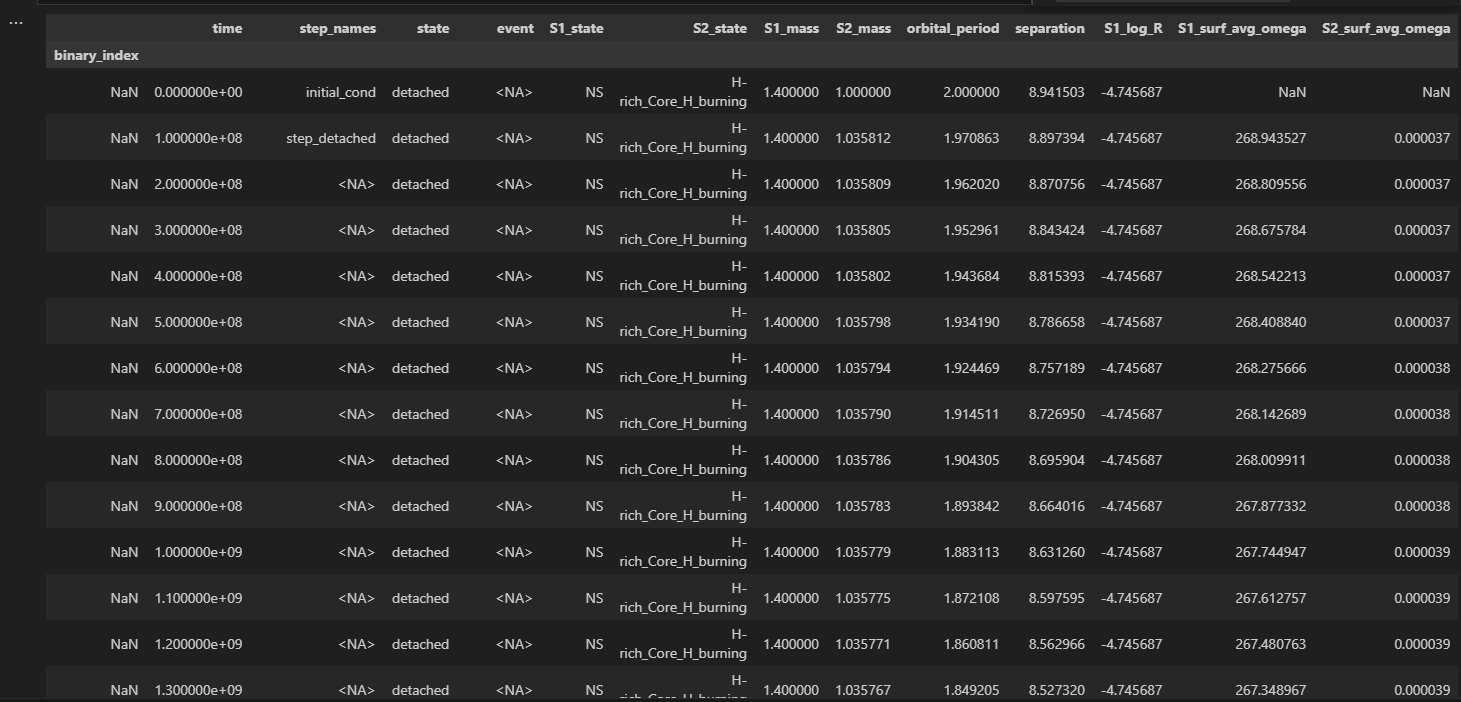

The neutron star's spin frequency $\Omega$ should be updated at each timestep, recorded in the column `S1_surf_avg_omega`. The spin period of the neutron star can then be calculated directly from the frequency, $P = 2 \pi/\Omega$.

To summarize, we created our own custom magnetic braking prescription for neutron stars and successfully integrated it within $\texttt{POSYDON}$'s `step_detached` framework. This provides a foundation for similar exercises that can be built within $\texttt{POSYDON}$'s detached step, allowing us to experiment with custom prescriptions for magnetic braking, tides, stellar winds, etc, rather than running $\texttt{MESA}$ models from scratch.